<h1>TP8 Deep Learning</h1>

Cette huitième séance est composée de deux parties :
* Transfert de style, basé sur l'article "Image Style Transfer Using Convolutional Neural Networks" [Gatys, 2016]
* Transférabilité de features, basé sur l'article "How transferable are features in deep neural networks?" [Yosinsky, 2014]


<h2> Transfert de style</h2>

Cette partie vise à l'implémentation de la méthode présentée dans l'article "Image Style Transfer Using Convolutional Neural Networks", permettant de transférer le style d'une image <i>S</i> sur une image de contenu <i>C</i>. L'approche consiste à trouver l'image qui minimise une fonction <i>loss</i> constituée de deux termes : l'un visant à aligner les features d'une couche élevée entre l'image <i>contenue</i> et l'image générée <i>x</i> ; l'autre aligne les <i>matrices de gram</i> (covariances) obtenues sur des couches inférieures entre l'image <i>style</i> et l'image générée <i>x</i>.

Commençons par télécharger quelques images :

In [1]:
!wget https://pageperso.lis-lab.fr/stephane.ayache/TP_style/content_cat.png
!wget https://pageperso.lis-lab.fr/stephane.ayache/TP_style/content_bridge.png
!wget https://pageperso.lis-lab.fr/stephane.ayache/TP_style/content_joconde.png
!wget https://pageperso.lis-lab.fr/stephane.ayache/TP_style/style_hokusai.png
!wget https://pageperso.lis-lab.fr/stephane.ayache/TP_style/style_hopper.png
!wget https://pageperso.lis-lab.fr/stephane.ayache/TP_style/stef.jpg
!wget https://pageperso.lis-lab.fr/stephane.ayache/TP_style/miro.jpg

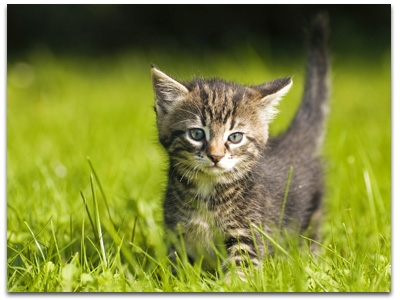

In [2]:
from PIL import Image
from IPython.display import display
display(Image.open("content_cat.png"))

Pour information, voici ce que vous devriez obtenir après application du style Van Gogh et HokusaÏ. Les résultats peuvent changer selon les constantes définies en début du notebook.

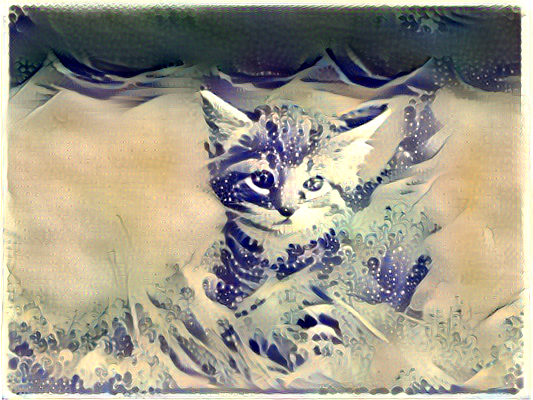

In [3]:
display(Image.open("cat_hokusai.png"))

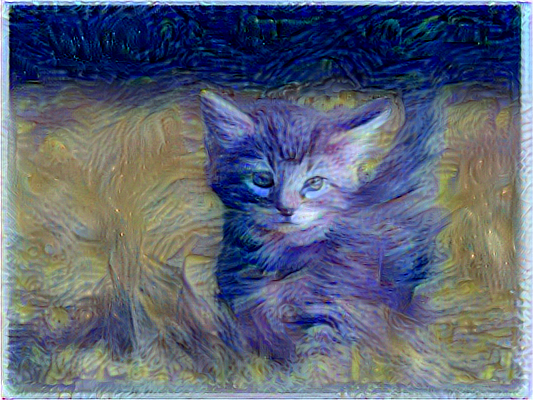

In [4]:
display(Image.open("cat_vangogh.png"))

<h4>Import des packages et définition de quelques constantes</h4>

In [6]:
import numpy as np
import tensorflow.keras.backend as K
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Define constants
CONTENT_IMG_PATH = 'content_joconde.png'
STYLE_IMG_PATH = 'style_hopper.png' #'style_hokusai.png' #'style_vangogh.png' #'style_mead.png' #'style_kandinsky.png' #'style.jpg'

# Number of iterations to run
ITER = 10

# Weights of losses
CONTENT_WEIGHT = 0.01
STYLE_WEIGHT = 1000.0

# Define the shape of the output image
h, w = load_img(CONTENT_IMG_PATH).size
img_h = 400
img_w = int(h * img_h / w)

Les fonctions <i>preprocess</i> et <i>postprocess</i> sont utilisées pour formater et normaliser les images qui passeront dans le réseau VGG19 :

In [7]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

def preprocess(img_path):
    img = load_img(img_path)
    img = img_to_array(img)
    img = np.array(Image.fromarray(img.astype('uint8')).resize((img_w, img_h)))
    img = img.astype('float32')

    img = np.expand_dims(img, axis=0)

    img = vgg19.preprocess_input(img)
    return img


def postprocess(img):
    # Deprocess array from VGG19 to display image
    mean = [103.939, 116.779, 123.68]
    img2 = img[..., ::-1]
    img2 = img2[..., ::-1]
    #img2[..., 0] += mean[0]
    #img2[..., 1] += mean[1]
    #img2[..., 2] += mean[2]
    img2 = img2 + mean
    img2 = img2[..., ::-1]
    img2 = np.array(img2)
    #xx = xx.reshape((img_h, img_w, 3))
    #xx = np.clip(xx, 0, 255)
    return img2.astype('uint8')

[[[103.  87.  28.]
  [101.  85.  25.]
  [112.  96.  31.]
  ...
  [114.  94.  17.]
  [114.  94.  15.]
  [121. 102.  24.]]

 [[ 94.  76.  16.]
  [109.  91.  31.]
  [117.  99.  34.]
  ...
  [113.  93.  11.]
  [115.  94.  13.]
  [124. 104.  23.]]

 [[ 99.  77.  17.]
  [113.  92.  31.]
  [122. 102.  37.]
  ...
  [115.  94.  12.]
  [119.  98.  17.]
  [115.  95.  10.]]

 ...

 [[ 19.   5.  10.]
  [ 19.   5.  10.]
  [ 20.   6.  10.]
  ...
  [ 10.   2.   4.]
  [  9.   1.   3.]
  [ 11.   3.   5.]]

 [[ 18.   5.  10.]
  [ 18.   6.  10.]
  [ 19.   6.  10.]
  ...
  [ 12.   3.   6.]
  [ 10.   2.   5.]
  [ 10.   2.   4.]]

 [[ 19.   7.  11.]
  [ 19.   7.  11.]
  [ 18.   6.  10.]
  ...
  [ 11.   1.   5.]
  [  9.   1.   3.]
  [ 10.   1.   4.]]]
img2
[[[103.  87.  28.]
  [101.  85.  25.]
  [112.  96.  31.]
  ...
  [114.  94.  17.]
  [114.  94.  15.]
  [121. 102.  24.]]

 [[ 94.  76.  16.]
  [109.  91.  31.]
  [117.  99.  34.]
  ...
  [113.  93.  11.]
  [115.  94.  13.]
  [124. 104.  23.]]

 [[ 99.  77. 

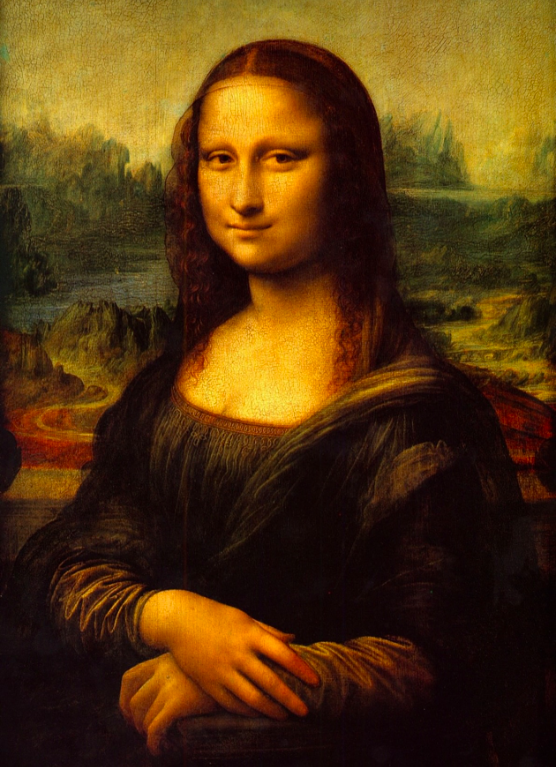

In [8]:
img = img_to_array(load_img(CONTENT_IMG_PATH))
print(img)
imgp = vgg19.preprocess_input(img)

mean = [103.939, 116.779, 123.68]
img2 = imgp[..., ::-1]
img2 = img2[..., ::-1]
img2[..., 0] += mean[0]
img2[..., 1] += mean[1]
img2[..., 2] += mean[2]
img2 = img2[..., ::-1]
print("img2")
print(img2)
Image.fromarray(img2.astype('uint8'))

<h4>Chargement d'un modèle préentrainé de l'architecture VGG19</h4>
On construit ici un tenseur <i>input_tensor</i> qui contient les images <i>contenu</i>, <i>style</i>, et celle <i>générée</i>. Ceci permet d'obtenir en une seule passe les features vgg19 des trois images.

In [9]:
# Create Keras variables of input images
#content_img = K.variable(preprocess(CONTENT_IMG_PATH))
#style_img = K.variable(preprocess(STYLE_IMG_PATH))
#gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

# Create a single tensor containing all three images
#input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)

# Create a vgg19 model by running the input tensor though the vgg19 convolutional
# neural network, excluding the fully connected layers
#model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Create an output dictionary
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
print('VGG model loaded')

VGG model loaded


Affiche la liste des couches du modèle et définissions des représentations de contenus et de style

In [10]:
for layer in vgg.layers:
  print(layer.name)

content_layers = ['block5_conv2']

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)



input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


La "functional API" de Keras permet de créer des modèles selon leur entrrées et sorties. Ici on créé un modèle qui retourne des couches internes de l'architecture VGG19.


In [11]:
# create keras model that outputs internal style layers
outputs = [vgg.get_layer(name).output for name in style_layers]
style_model = tf.keras.Model([vgg.input], outputs)

# create keras model that outputs internal content layers
outputs = [vgg.get_layer(name).output for name in content_layers]
content_model = tf.keras.Model([vgg.input], outputs)

<h4>Fonctions loss</h4>
Les fonctions suivantes permettent de définir la fonction objective pour le transfert de style. Cette loss est composée d'un terme <i>content</i> et d'un terme <i>style</i>. La notion de style est définie par la covariance entre les filtres de convolutions obtenus sur les couches basses du réseau VGG19.

<b>A Faire : </b> Compléter les quelques lignes de codes commentées par A COMPLETER.

In [12]:
def gram_matrix(x):
    gram = tf.linalg.einsum('bijc,bijd->bcd', x, x)
    input_shape = tf.shape(x)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return gram/(num_locations)

def style_loss(style, gen):
    S = gram_matrix(style)
    G = gram_matrix(gen)
    return K.mean(K.square(S - G)) #/ (4. * (channels ** 2) * (size ** 2))

def content_loss(content, gen):
    return K.mean(K.square(gen - content))

<h4>Définition d'une fonction qui renvoie le gradient de la loss par rapport à l'entrée du réseau</h4>

La partie ci-dessous est similaire à ce qu'on a vu pour la visualisation de filtre par maximisation d'activations. A la différence que plutôt que de maximiser des activations, on minimise la loss. On définie une fonction (Keras) qui renvoie les gradients, cette fonction nous permettra de mettre à jour l'image générée.

In [24]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

content_target = content_model(preprocess(CONTENT_IMG_PATH))
style_target = style_model(preprocess(STYLE_IMG_PATH))
gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    #outputs = extractor(image)
    #loss = style_content_loss(outputs)
    #inputs = inputs*255.0
    #preprocessed_input = tf.keras.applications.vgg19.preprocess_input(image)
    content = content_model(image)
    style = style_model(image)

    #loss = CONTENT_WEIGHT * content_loss(content_target, content)
    #for i in range(num_style_layers):
    #    s1 = style_loss(style_target[i], style[i])
    #    loss += (STYLE_WEIGHT / num_style_layers) * s1
    style_loss = tf.add_n([tf.reduce_mean((gram_matrix(style[i])-gram_matrix(style_target[i]))**2) for i in range(num_style_layers)])
    style_loss *= STYLE_WEIGHT / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_target[i])**2) for i in range(num_content_layers)])
    content_loss *= CONTENT_WEIGHT / num_content_layers
    loss = style_loss + content_loss
    tf.print("loss",loss)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

RuntimeError: Exception encountered when calling layer "block1_conv1" "                 f"(type Conv2D).

resource: Attempting to capture an EagerTensor without building a function.

Call arguments received by layer "block1_conv1" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(1, 400, 289, 3), dtype=float32)

In [17]:
image = tf.Variable(preprocess(CONTENT_IMG_PATH), dtype=tf.float32)

In [18]:
print('Styles:')
for i in range(num_style_layers):
  print("  ", vgg.layers[i].name)
  print("    shape: ", gram_matrix(style_target[i]).numpy().shape)
  print("    min: ", gram_matrix(style_target[i]).numpy().min())
  print("    max: ", gram_matrix(style_target[i]).numpy().max())
  print("    mean: ", gram_matrix(style_target[i]).numpy().mean())
  print()

print("Contents:")
for i in range(num_content_layers):
  print("  ", vgg.layers[i].name)
  print("    shape: ", content_target[i].numpy().shape)
  print("    min: ", content_target[i].numpy().min())
  print("    max: ", content_target[i].numpy().max())
  print("    mean: ", content_target[i].numpy().mean())

content = content_model(image)
style = style_model(image)

print('im Styles:')
for i in range(num_style_layers):
  print("  ", vgg.layers[i].name)
  print("    shape: ", gram_matrix(style[i]).numpy().shape)
  print("    min: ", gram_matrix(style[i]).numpy().min())
  print("    max: ", gram_matrix(style[i]).numpy().max())
  print("    mean: ", gram_matrix(style[i]).numpy().mean())
  print()

print("im Contents:")
for i in range(num_content_layers):
  print("  ", vgg.layers[i].name)
  print("    shape: ", content[i].numpy().shape)
  print("    min: ", content[i].numpy().min())
  print("    max: ", content[i].numpy().max())
  print("    mean: ", content[i].numpy().mean())

Styles:
   input_1
    shape:  (1, 64, 64)
    min:  0.00015711418
    max:  28034.514
    mean:  437.391

   block1_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  106251.41
    mean:  10548.783

   block1_conv2
    shape:  (1, 256, 256)
    min:  0.0
    max:  481508.9
    mean:  14216.506

   block1_pool
    shape:  (1, 512, 512)
    min:  0.0
    max:  4419850.0
    mean:  172818.05

   block2_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  65795.78
    mean:  1160.2192

Contents:
   input_1
    shape:  (25, 18, 512)
    min:  0.0
    max:  2084.77
    mean:  17.147816
im Styles:
   input_1
    shape:  (1, 64, 64)
    min:  0.0
    max:  39575.562
    mean:  574.51715

   block1_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  72872.164
    mean:  13130.3545

   block1_conv2
    shape:  (1, 256, 256)
    min:  0.0
    max:  489021.16
    mean:  12950.205

   block1_pool
    shape:  (1, 512, 512)
    min:  0.0
    max:  8275911.0
    mean:  229595.9

   block2

<tf.Variable 'Variable:0' shape=(1, 400, 289, 3) dtype=float32, numpy=
array([[[[ -78.939    ,  -31.779    ,  -21.68     ],
         [ -68.939    ,  -15.778999 ,   -4.6800003],
         [ -67.939    ,   -6.7789993,    6.3199997],
         ...,
         [ -78.939    ,  -15.778999 ,   -3.6800003],
         [ -87.939    ,  -22.779    ,   -9.68     ],
         [ -85.939    ,  -18.779    ,   -5.6800003]],

        [[ -76.939    ,  -29.779    ,  -14.68     ],
         [ -73.939    ,  -19.779    ,   -6.6800003],
         [ -70.939    ,   -9.778999 ,    3.3199997],
         ...,
         [ -85.939    ,  -16.779    ,   -3.6800003],
         [ -86.939    ,  -18.779    ,   -5.6800003],
         [ -87.939    ,  -17.779    ,   -5.6800003]],

        [[ -72.939    ,  -27.779    ,   -9.68     ],
         [ -75.939    ,  -21.779    ,   -7.6800003],
         [ -76.939    ,  -15.778999 ,   -1.6800003],
         ...,
         [ -82.939    ,   -9.778999 ,    1.3199997],
         [ -77.939    ,  -10.778999

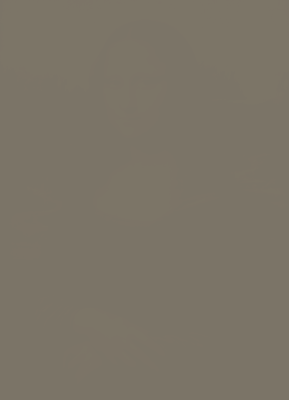

In [19]:
epochs = 0
steps_per_epoch = 10
image = tf.Variable(preprocess(CONTENT_IMG_PATH), dtype=tf.float32)
print(image)
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  #display.clear_output(wait=True)
  #display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

train_step(image)
print(image)
img = postprocess(image[0])
display(Image.fromarray(img))

tf.Tensor(
[[[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0. 255.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0. 255.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0. 255.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 ...

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]], shape=(400, 289, 3), dtype=float32)


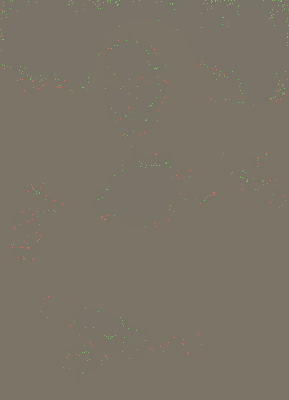

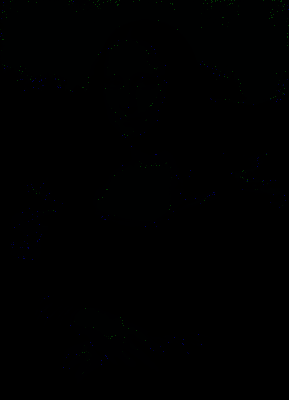

In [20]:
img = image[0]*255.
print(img)
mean = [103.939, 116.779, 123.68]
img2 = img[..., ::-1]
img2 = img2[..., ::-1]
img2 = np.array(img2)
img2[..., 0] += mean[0]
img2[..., 1] += mean[1]
img2[..., 2] += mean[2]
img2 = img2[..., ::-1]
img2 = img2.astype('uint8')
#img = postprocess(image[0])
display(Image.fromarray(img2))

tensor_to_image(image*255)

In [22]:
def compute_loss(gen_img, content_target, style_target, content_model, style_model):
    # Obtenir les sorties des modèles de contenu et de style pour l'image générée
    content_features = content_model(gen_img)
    style_features = style_model(gen_img)

    # Calcul de la perte de contenu
    content_loss_value = tf.add_n([
        tf.reduce_mean((content_features[i] - content_target[i])**2)
        for i in range(len(content_target))
    ])
    content_loss_value *= CONTENT_WEIGHT / len(content_target)

    # Calcul de la perte de style
    style_loss_value = tf.add_n([
        tf.reduce_mean((gram_matrix(style_features[i]) - gram_matrix(style_target[i]))**2)
        for i in range(len(style_target))
    ])
    style_loss_value *= STYLE_WEIGHT / len(style_target)

    # Combinaison des pertes
    total_loss = content_loss_value + style_loss_value
    return total_loss


In [23]:
tf.compat.v1.disable_eager_execution()
import sys
sys.setrecursionlimit(15000)
loss = compute_loss(gen_img, content_target, style_target, content_model, style_model)

# Calculate gradients of the loss wrt inputs
grads = K.gradients(loss, gen_img)

# Define a Keras function that return both loss and gradients
f_output = K.function([gen_img], [loss] + grads)

TypeError: compute_loss() missing 5 required positional arguments: 'gen_img', 'content_target', 'style_target', 'content_model', and 'style_model'

<h4>Minimisation par l'algorithme d'optimisation pseudo-newtonien L-BFGS</h4>

On utilise la fonction <i>fmin_l_bfgs_b</i> du package <i>scikit</i>, pour cela on a besoin des deux fonctions suivantes :

In [ ]:
grad_values = None
def get_grad_values(x):
    return grad_values

def eval_loss_and_grads(x):
    global grad_values
    x = x.reshape((1, img_h, img_w, 3))
    # Update the loss and the gradients
    outs = f_output([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value

In [ ]:
# Run L-BFGS optimizer, start from content image
x = preprocess(CONTENT_IMG_PATH)

for i in range(ITER):
    print('Step', i)
    x, min_val, info = fmin_l_bfgs_b(eval_loss_and_grads, x.flatten(), fprime=get_grad_values, maxiter=20)
    print('loss:', min_val)

    # display image
    img = postprocess(x)
    display(Image.fromarray(img.astype('uint8')))

<h2>Finetuning et Transfert de modèles</h2>

Cette partie reprend certaines expériences décrites dans l'article "How transferable are features in deep neural networks?" [Yosinski, 2014]"

Features that are extracted by NN in their hidden layers are known to be generic. To study this property we will consider two 5-classes classification tasks based on the MNIST dataset: Classifying digits 0 to 4 (task A, and Dataset A) and classifying digits 5 to 9 (task B and Dataset B).

- Learn a NN on MNIST data using data from classes 0 à 4, or data from classes 5 to 9. Learn a model for each task using the whole dataset, NNA and NNB. All models have the same default architecture as defined in the function create_modelCNN_MNIST defined below.
- Use NNA to initialize models that will be learned on DatasetB. The models have the same architecture but their weights are initialized from those of NNA up to layer number 1, 2 or 3 (other weights are initailized randomly). The models are retrained using data from taskB with datasets of various sizes. Weights initialized from NNA may be frozen or trainable.
The same procedure should be applied to use NNB to initialize models that will be retrained on TaskA and datasets A.
- Analyze your results and comment on these.

<h4>Chargement des données</h4>

In [ ]:
import keras
from keras.datasets import mnist

img_rows = img_cols = 28
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.to_categorical(y_test, nb_classes)

<h4>Définition de l'architecture considérée pour l'expérience</h4>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D


def create_modelCNN_MNIST(nb_classes = 10, nb_filters = 32, pool_size=(2,2), kernel_size = (3,3)):
    model1 = Sequential()
    model1.add(Conv2D(nb_filters, kernel_size, padding='same', input_shape=input_shape))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=pool_size))
    model1.add(Conv2D(nb_filters, kernel_size, padding='same'))
    model1.add(Activation('relu'))
    model1.add(MaxPooling2D(pool_size=pool_size))
    model1.add(Dropout(0.5))

    model1.add(Flatten())
    model1.add(Dense(100))
    model1.add(Activation('relu'))
    model1.add(Dropout(0.5))
    model1.add(Dense(nb_classes))
    model1.add(Activation('softmax'))

    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model1)

cnn1 = create_modelCNN_MNIST()
print (cnn1.summary())

<h4> Construction des datasets pour les taches A et B</h4>

In [ ]:
indices_0to4 = np.where(y_train <5)
Y_train_04 = np.squeeze(Y_train[indices_0to4,0:5])
X_train_04 = X_train[indices_0to4]
y_train_04 = np.argmax(Y_train_04, axis=1)

indices_0to4 = np.where(y_test <5)
Y_test_04 = np.squeeze(Y_test[indices_0to4,0:5])
X_test_04 = X_test[indices_0to4]
y_test_04 = np.argmax(Y_test_04, axis=1)

print (Y_train_04.shape, X_train_04.shape, Y_test_04.shape, X_test_04.shape)

indices_5to9 = np.where(y_train >4)
Y_train_59 = np.squeeze(Y_train[indices_5to9, 5:])
X_train_59 = X_train[indices_5to9]
y_train_59 = np.argmax(Y_train_59, axis=1)

indices_5to9 = np.where(y_test >4)
Y_test_59 = np.squeeze(Y_test[indices_5to9,5:])
X_test_59 = X_test[indices_5to9]
y_test_59 = np.argmax(Y_test_59, axis=1)

print (Y_train_59.shape, X_train_59.shape, Y_test_59.shape, X_test_59.shape)

<h4>Apprentissage du modèle sur le dataset A sur les digits 0 .. 4 </h4>

In [ ]:
cnn_04 = create_modelCNN_MNIST(nb_classes=5)
print (cnn_04.summary())

batch_size = 128
nb_epoch = 20

WEIGHTS_FNAME = 'Mnist_Cnn04_My_weights.hdf'

cnn_04.fit(X_train_04, Y_train_04, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(X_test_04, Y_test_04))
cnn_04.save_weights(WEIGHTS_FNAME)

score = cnn_04.evaluate(X_test_04, Y_test_04, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

<h4>Apprentissage du modèle sur le dataset B sur les digits 5 .. 9 </h4>

In [ ]:
cnn_59 = create_modelCNN_MNIST(nb_classes=5)
print (cnn_59.summary())

WEIGHTS_FNAME = 'Mnist_Cnn59_My_weights.hdf'

cnn_59.fit(X_train_59, Y_train_59, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(X_test_59, Y_test_59))
cnn_59.save_weights(WEIGHTS_FNAME)

score = cnn_59.evaluate(X_test_59, Y_test_59, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])



<b>A faire :</b> On s'intéresse à reproduire les expériences décrites dans l'article. Constuire un modèle où les premières couches 1, 2 ou 3 sont initialisées à partir du modèle NNA, les autres couches sont initialisées aléatoirement. Le modèle est réentrainé avec les données de taskB. Les poids provenant de NNA peuvent être réentrainés ou figés (utilisés l'attribut trainable = False pour figer une couche). Faire la même expérience en inversant les modèles/taches (NNB, entrainé sur TaskA).